In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet
from sklearn.svm import SVC


# Preprocess audio file into Mel Spectrogram
def preprocess_audio_file(file_path, target_shape=(224, 224)):
    """
    Converts a .wav file into a Mel Spectrogram, resizes it for InceptionV3, 
    and normalizes pixel values.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0  # Normalize to [0, 1]
        return rgb_spec
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process directory of sounds into spectrograms and labels
def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):
    """
    Processes all .wav files in a directory and its subdirectories,
    computes their Mel Spectrograms, and stores them in a DataFrame.
    """
    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  # Subdirectory name is the label
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                spectrogram = preprocess_audio_file(file_path, target_shape)
                if spectrogram is not None:
                    data.append(spectrogram)
                    labels.append(label)
    return np.array(data), np.array(labels)

# Path to the parent directory containing labeled subdirectories of .wav files
parent_directory = "Animal_Sounds"  # Replace with your dataset directory

# Process audio files and labels
print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Processing audio files...


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Encoding labels...
Splitting data into train and test sets...


In [2]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

Loading pre-trained MobileNet model...


In [3]:
# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

Extracting features using the pre-trained MobileNet model...
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Training the Logistic Regression classifier...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating the Logistic Regression classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        16
           1       1.00      1.00      1.00        19
           2       0.79      0.81      0.80        27
           3       0.83      0.71      0.77         7
           4       0.93      0.96      0.95        28
           5       0.78      0.78      0.78        18
           6       0.80      0.86      0.83        14
           7       0.70      0.78      0.74         9
           8       0.76      0.87      0.81        15
           9       0.11      0.11      0.11         9
          10       0.00      0.00      0.00         3
          11       0.88      0.70      0.78        10

    accuracy                           0.76       175
   macro avg       0.66      0.66      0.66       175
weighted avg       0.75      0.76      0.75       175



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


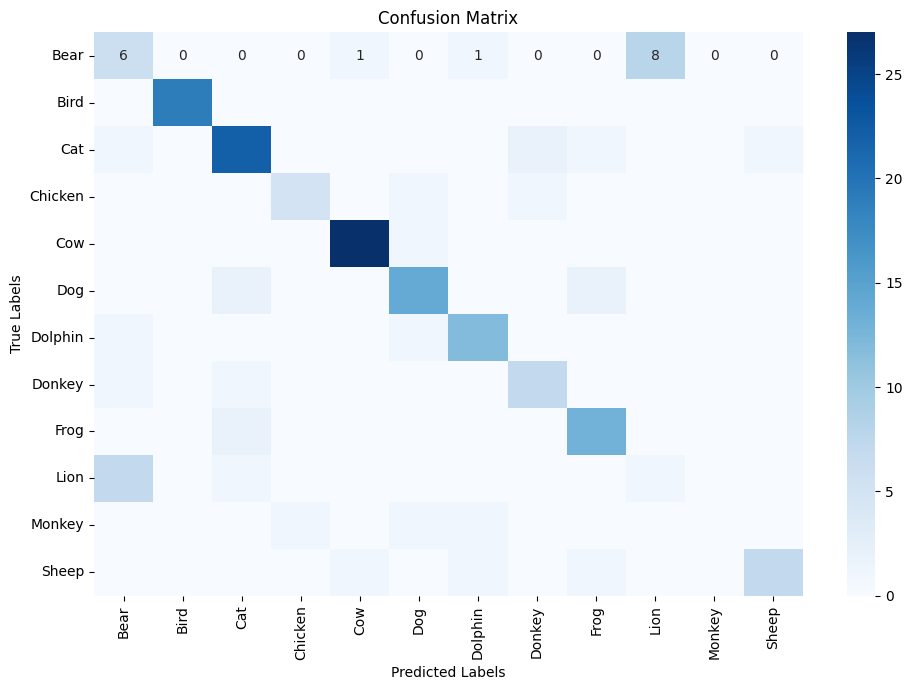

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train Logistic Regression Classifier
print("Training the Logistic Regression classifier...")
lr_model = LogisticRegression(
    max_iter=1000,  # Increase max iterations for convergence
    random_state=42,
    multi_class='multinomial',  # For multi-class classification
    solver='lbfgs'              # Recommended solver for multiclass tasks
)
lr_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the Logistic Regression classifier...")
y_pred = lr_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()